# Final Assignment A

Kamile Stankeviciute `ks830`

In [60]:
import os
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import scipy
import math


import sklearn

from sklearn.model_selection import StratifiedShuffleSplit
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.base import TransformerMixin, BaseEstimator 
from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import Pipeline, FeatureUnion
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# from sklearn.ensemble import VotingClassifier

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC

# from sklearn.metrics import accuracy_score

# from sklearn.ensemble import BaggingClassifier
# from sklearn.tree import DecisionTreeClassifier

# from sklearn.ensemble import AdaBoostClassifier

# from sklearn.tree import DecisionTreeRegressor

# from sklearn.ensemble import GradientBoostingRegressor

# import sklearn.linear_model
# import scipy.optimize
# import sklearn.decomposition
# import sklearn.manifold
# import sklearn.model_selection

# Preprocessing

Note that the dataset contains a combination of *categorical- and numerical-valued* features. It also contains a number of *missing values*. 
Explore different features in the dataset (e.g., you might want to remove features with mostly missing values), gain insights from the data and report your findings.

Visualise the dataset and the predicted variable:
* `<30` if the patient was readmitted in less than 30 days
* `>30` if the patient was readmitted in more than 30 days
* `No` if there is no record for readmission (but absence of evidence is not evidence of absence ;))

Remove missing columns:
* 'weight': 97% missing
* 'payer_code': 52% missing, generally irrelevant
* 'medical_specialty': 53% missing, ??

In [69]:
# Loading the dataset
pd.set_option('display.max_rows', 500)

diabetic = pd.read_csv('diabetes/diabetic_data_balanced.csv')
diabetic.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [18]:
diabetic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 50 columns):
encounter_id                9999 non-null int64
patient_nbr                 9999 non-null int64
race                        9819 non-null object
gender                      9999 non-null object
age                         9999 non-null object
weight                      300 non-null object
admission_type_id           9999 non-null int64
discharge_disposition_id    9999 non-null int64
admission_source_id         9999 non-null int64
time_in_hospital            9999 non-null int64
payer_code                  235 non-null object
medical_specialty           6362 non-null object
num_lab_procedures          9999 non-null int64
num_procedures              9999 non-null int64
num_medications             9999 non-null int64
number_outpatient           9999 non-null int64
number_emergency            9999 non-null int64
number_inpatient            9999 non-null int64
diag_1                   

## Anonymisation

The dataset contains some patient-identifying information (patient number) which don't want any future machine learning models to use as an indicator for predicted variable. We observe that the dataset contains multiple encounters for the same patient: 

In [47]:
diabetic['patient_nbr'].value_counts()

1660293     15
3481272     12
3401055     12
23643405    11
633906      11
            ..
7067862      1
78346458     1
5812695      1
70858503     1
102402       1
Name: patient_nbr, Length: 7944, dtype: int64

In [38]:
diabetic_no_med_specialty = diabetic[diabetic['medical_specialty'].isnull()]
diabetic_no_med_specialty = diabetic_no_med_specialty.drop(['encounter_id', 'patient_nbr'], axis=1)
diabetic_no_med_specialty.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000,3637.000000
mean,2.179269,4.625241,6.767116,5.139951,46.248831,1.615892,16.687105,0.165796,0.092659,0.663459,7.108606
std,1.556872,5.681358,5.127842,3.298321,18.255429,1.813984,8.941903,0.803086,0.547465,1.348722,1.911987
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,3.000000,3.000000,34.000000,0.000000,11.000000,0.000000,0.000000,0.000000,6.000000
50%,2.000000,1.000000,7.000000,4.000000,47.000000,1.000000,15.000000,0.000000,0.000000,0.000000,7.000000
75%,3.000000,6.000000,7.000000,7.000000,59.000000,3.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,8.000000,25.000000,20.000000,14.000000,108.000000,6.000000,62.000000,12.000000,22.000000,17.000000,9.000000


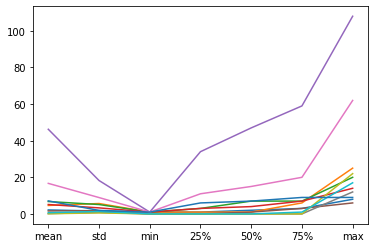

In [41]:
plt.plot(diabetic_no_med_specialty.describe().drop('count', axis=0))

In [45]:
diabetic_med_specialty = diabetic[diabetic['medical_specialty'].notnull()]
diabetic_med_specialty = diabetic_med_specialty.drop(['encounter_id', 'patient_nbr'], axis=1)
diabetic_med_specialty.describe()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000,6362.000000
mean,2.613486,4.794719,6.696165,4.666929,47.225244,1.348318,14.513046,0.077020,0.049041,0.656712,6.768312
std,2.004497,7.351035,4.918415,3.076942,18.046814,1.663772,7.145152,0.418909,0.367843,1.352637,2.051931
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,1.000000,1.000000,2.000000,36.000000,0.000000,9.000000,0.000000,0.000000,0.000000,5.000000
50%,2.000000,1.000000,7.000000,4.000000,48.000000,1.000000,13.000000,0.000000,0.000000,0.000000,7.000000
75%,5.000000,5.000000,7.000000,6.000000,60.000000,2.000000,19.000000,0.000000,0.000000,1.000000,9.000000
max,8.000000,25.000000,17.000000,14.000000,114.000000,6.000000,62.000000,7.000000,10.000000,15.000000,9.000000


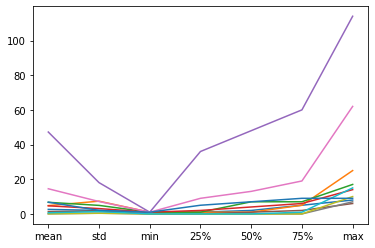

In [46]:
plt.plot(diabetic_med_specialty.describe().drop('count', axis=0))

I will therefore analyse just one instance per patient (so that repeating information for the same person does not skew the distribution), and will remove the patient number and encounter identifier.

In [70]:
diabetic = diabetic.groupby('patient_nbr', group_keys=False).apply(lambda df: df.sample(1))
diabetic

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
4780,26264286,135,Caucasian,Female,[50-60),NaN,1,1,7,3,...,No,No,No,No,No,No,No,Ch,Yes,>30
5827,29758806,378,Caucasian,Female,[50-60),NaN,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
2270,14824206,927,AfricanAmerican,Female,[30-40),NaN,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,NO
5953,30180318,1152,AfricanAmerican,Female,[50-60),NaN,1,1,7,6,...,No,Down,No,No,No,No,No,Ch,Yes,>30
8926,70190028,1314,Caucasian,Female,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,No,Yes,<30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9904,92021862,115036947,Caucasian,Male,[80-90),NaN,1,22,7,7,...,No,No,No,No,No,No,No,No,Yes,<30
3112,19760178,115042869,Caucasian,Male,[60-70),NaN,1,1,7,2,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
2913,18658488,115066152,Caucasian,Female,[80-90),NaN,6,1,17,1,...,No,No,No,No,No,No,No,Ch,Yes,>30
5754,29467458,115187499,AfricanAmerican,Female,[40-50),NaN,1,1,7,2,...,No,Steady,No,No,No,No,No,Ch,Yes,>30


In [71]:
diabetic_pre = diabetic.copy()

In [75]:
diabetic = diabetic_pre.copy()

In [76]:
diabetic = diabetic.drop(['encounter_id', 'patient_nbr'], axis=1)

## Splitting into train and test

In [77]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(diabetic, diabetic['readmitted']):
    strat_train_set = diabetic.loc[train_index]
    strat_test_set = diabetic.loc[test_index]
    
diabetic = strat_train_set.drop("readmitted", axis=1)
diabetic_labels = strat_train_set["readmitted"].copy()

/Users/kamilestankeviciute/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/Users/kamilestankeviciute/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """


In [78]:
diabetic

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
6548,AfricanAmerican,Female,[10-20),NaN,2.0,6.0,2.0,4.0,NaN,Family/GeneralPractice,...,No,No,Steady,No,No,No,No,No,Ch,Yes
3176,Caucasian,Male,[60-70),NaN,3.0,1.0,1.0,7.0,NaN,Surgery-Cardiovascular/Thoracic,...,No,No,Steady,No,No,No,No,No,Ch,Yes
1350,Caucasian,Female,[0-10),NaN,1.0,1.0,4.0,5.0,NaN,Pediatrics-CriticalCare,...,No,No,Steady,No,No,No,No,No,No,Yes
3960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7941,Caucasian,Male,[70-80),NaN,1.0,18.0,7.0,3.0,NaN,NaN,...,No,No,Steady,No,No,No,No,No,Ch,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4108,Caucasian,Female,[70-80),NaN,3.0,1.0,1.0,4.0,NaN,NaN,...,No,No,Down,No,No,No,No,No,Ch,Yes
7693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Counting what proportion of values is absent from the dataset:

In [54]:
1 - diabetic.count()/len(diabetic)

race                        0.021148
gender                      0.000000
age                         0.000000
admission_type_id           0.000000
discharge_disposition_id    0.000000
admission_source_id         0.000000
time_in_hospital            0.000000
medical_specialty           0.000000
num_lab_procedures          0.000000
num_procedures              0.000000
num_medications             0.000000
number_outpatient           0.000000
number_emergency            0.000000
number_inpatient            0.000000
diag_1                      0.000504
diag_2                      0.005161
diag_3                      0.026309
number_diagnoses            0.000000
max_glu_serum               0.000000
A1Cresult                   0.000000
metformin                   0.000000
repaglinide                 0.000000
nateglinide                 0.000000
chlorpropamide              0.000000
glimepiride                 0.000000
acetohexamide               0.000000
glipizide                   0.000000
g

In [52]:
diabetic = diabetic.drop(['weight', 'payer_code'], axis=1)

In [53]:
diabetic['medical_specialty'].fillna('Missing', inplace=True)
diabetic

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
4267,Caucasian,Female,[50-60),2,1,1,8,Cardiology,77,6,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
5827,Caucasian,Female,[50-60),3,1,1,2,Surgery-Neuro,49,1,...,No,No,No,No,No,No,No,No,No,NO
2270,AfricanAmerican,Female,[30-40),1,1,7,5,InternalMedicine,49,0,...,No,No,No,No,No,No,No,No,Yes,NO
1164,AfricanAmerican,Female,[50-60),1,1,7,6,Hematology/Oncology,43,2,...,No,Steady,No,No,No,No,No,No,Yes,>30
8926,Caucasian,Female,[40-50),1,1,7,1,InternalMedicine,47,5,...,No,Steady,No,No,No,No,No,No,Yes,<30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9904,Caucasian,Male,[80-90),1,22,7,7,Orthopedics-Reconstructive,47,1,...,No,No,No,No,No,No,No,No,Yes,<30
3112,Caucasian,Male,[60-70),1,1,7,2,Missing,61,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
2913,Caucasian,Female,[80-90),6,1,17,1,Cardiology,47,5,...,No,No,No,No,No,No,No,Ch,Yes,>30
5754,AfricanAmerican,Female,[40-50),1,1,7,2,Missing,53,0,...,No,Steady,No,No,No,No,No,Ch,Yes,>30


Since we are primarily studying diabetic patients, the other diagnoses are not as important. It still makes sense to fill the missing categorial values with a special value like "None".

In [55]:
diabetic['diag_1'].fillna('None', inplace=True)
diabetic['diag_2'].fillna('None', inplace=True)
diabetic['diag_3'].fillna('None', inplace=True)
diabetic['race'].fillna('Missing', inplace=True)

In [56]:
diabetic

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
4267,Caucasian,Female,[50-60),2,1,1,8,Cardiology,77,6,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
5827,Caucasian,Female,[50-60),3,1,1,2,Surgery-Neuro,49,1,...,No,No,No,No,No,No,No,No,No,NO
2270,AfricanAmerican,Female,[30-40),1,1,7,5,InternalMedicine,49,0,...,No,No,No,No,No,No,No,No,Yes,NO
1164,AfricanAmerican,Female,[50-60),1,1,7,6,Hematology/Oncology,43,2,...,No,Steady,No,No,No,No,No,No,Yes,>30
8926,Caucasian,Female,[40-50),1,1,7,1,InternalMedicine,47,5,...,No,Steady,No,No,No,No,No,No,Yes,<30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9904,Caucasian,Male,[80-90),1,22,7,7,Orthopedics-Reconstructive,47,1,...,No,No,No,No,No,No,No,No,Yes,<30
3112,Caucasian,Male,[60-70),1,1,7,2,Missing,61,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
2913,Caucasian,Female,[80-90),6,1,17,1,Cardiology,47,5,...,No,No,No,No,No,No,No,Ch,Yes,>30
5754,AfricanAmerican,Female,[40-50),1,1,7,2,Missing,53,0,...,No,Steady,No,No,No,No,No,Ch,Yes,>30


# Data exploration

/Users/kamilestankeviciute/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/Users/kamilestankeviciute/anaconda3/envs/datasci/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
2705,Other,Female,[60-70),6.0,1.0,7.0,4.0,Missing,58.0,0.0,...,No,No,No,No,No,No,No,No,No,NO
1012,Missing,Female,[40-50),2.0,6.0,4.0,5.0,Missing,39.0,2.0,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
4570,AfricanAmerican,Male,[60-70),1.0,1.0,7.0,12.0,Missing,92.0,1.0,...,No,Steady,No,No,No,No,No,No,Yes,NO
3170,AfricanAmerican,Male,[40-50),1.0,1.0,7.0,5.0,Missing,63.0,0.0,...,No,Steady,No,No,No,No,No,No,Yes,>30
2979,Caucasian,Male,[50-60),1.0,1.0,7.0,8.0,InternalMedicine,48.0,1.0,...,No,Down,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7030,AfricanAmerican,Female,[70-80),1.0,6.0,7.0,8.0,Missing,75.0,3.0,...,No,No,No,No,No,No,No,No,No,>30
5436,Caucasian,Female,[80-90),1.0,3.0,7.0,11.0,InternalMedicine,62.0,0.0,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5774,Missing,Male,[60-70),1.0,1.0,7.0,5.0,Missing,75.0,1.0,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
1279,Caucasian,Male,[50-60),1.0,1.0,7.0,2.0,Surgery-General,47.0,2.0,...,No,No,No,No,No,No,No,No,No,NO


In [67]:
diabetic = strat_train_set.drop("readmitted", axis=1)
diabetic_labels = strat_train_set["readmitted"].copy()

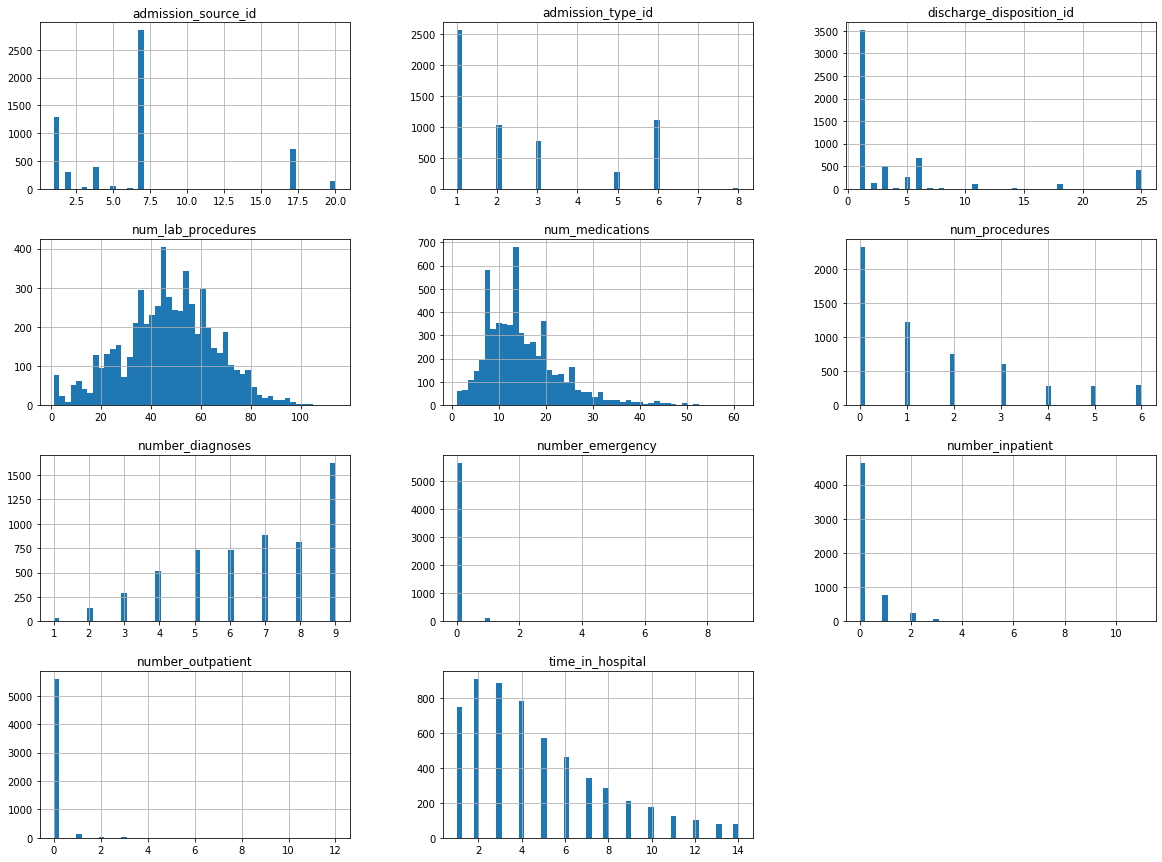

In [68]:
%matplotlib inline 
import matplotlib.pyplot as plt

diabetic.hist(bins=50, figsize=(20,15))
plt.show()